In [1]:
%%capture
%cd '../../src'

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set_palette('Set2')
sns.set_style('whitegrid')

from sklearn.metrics import f1_score

In [3]:
paths = [f for f in os.listdir('../models/hslstm/') if '.DS_Store' not in f]
len(paths)

55

In [4]:
def get_train_setup_params(path):
    [in_freq, lookahead, pct_thresh, _] = path.split('-')
    in_freq = int(in_freq.replace('in_freq', '')[:-1])
    lookahead = int(lookahead.replace('lookahead', ''))
    pct_thresh = int(pct_thresh.replace('pct_thresh', ''))
    return in_freq, lookahead, pct_thresh

In [5]:
def get_score(path):
    cols = ['ticker', 'start', 'end', 'target', 'prob_0', 'prob_1', 'prob_2', 'prob_3', 'pred_label']
    try:
        with open(f'../models/hslstm/{path}/eval_results3.pkl', 'rb') as f:
            d = pickle.load(f)
            d = pd.DataFrame(d, columns = cols)
            score = f1_score(y_true = d['target'], y_pred = d['pred_label'], average = 'weighted')
            ind_scores = {}
            for lbl in sorted(d['target'].unique()):
                sub = d[d['target'] == lbl]
                ind_scores[lbl] = f1_score(y_true = sub['target'], y_pred = sub['pred_label'], average = 'weighted')
            dict_target_counts = dict(d['target'].value_counts() / len(d))
            return score, dict_target_counts, ind_scores
    except:
        return None

In [6]:
data = []
tgt_dist = []
for path in paths:
    in_freq, lookahead, pct_thresh = get_train_setup_params(path)
    output = get_score(path)
    if output:
        score, dict_n_tgt, ind_scores = output
        data.append((in_freq, lookahead, pct_thresh, score, ind_scores[0], ind_scores[1], ind_scores[2], ind_scores[3]))
        for k, v in dict_n_tgt.items():
            tgt_dist.append((in_freq, lookahead, pct_thresh, k, v))

d = pd.DataFrame(data, columns = ['in_freq', 'lookahead', 'pct_thresh', 'f1_score', 'score_0', 'score_1', 'score_2', 'score_3'])
tgt_df = pd.DataFrame(tgt_dist, columns = ['in_freq', 'lookahead', 'pct_thresh', 'label', 'pct_samples'])
tgt_df['label'] = tgt_df['label'].map({0 : 'neither', 1: 'long', 2: 'short', 3: 'either'})
tgt_df.head()

,in_freq,lookahead,pct_thresh,label,pct_samples
0,240,3,1,short,0.363467
1,240,3,1,long,0.352501
2,240,3,1,neither,0.220522
3,240,3,1,either,0.063510
4,120,3,1,neither,0.385973


In [7]:
# threshs = sorted(d['pct_thresh'].unique())
# for lookahead in [2, 3, 4, 5]:
#     fig, axes = plt.subplots(1, 3, figsize = (16, 4))
#     for idx, ax in enumerate(axes.flatten()):
#         sns.barplot(data = tgt_df[(tgt_df['pct_thresh'] == threshs[idx]) & (tgt_df['lookahead'] == lookahead)], 
#                     x = 'label', y = 'pct_samples', hue = 'in_freq', 
#                     order = ['neither', 'long', 'short', 'either'], ax = ax)
#         ax.set_title(f'Pct thresh: {threshs[idx]}%; lookahead {lookahead} time units')
#         if idx != 0:
#             ax.legend().remove()
#     plt.tight_layout()
#     plt.show()

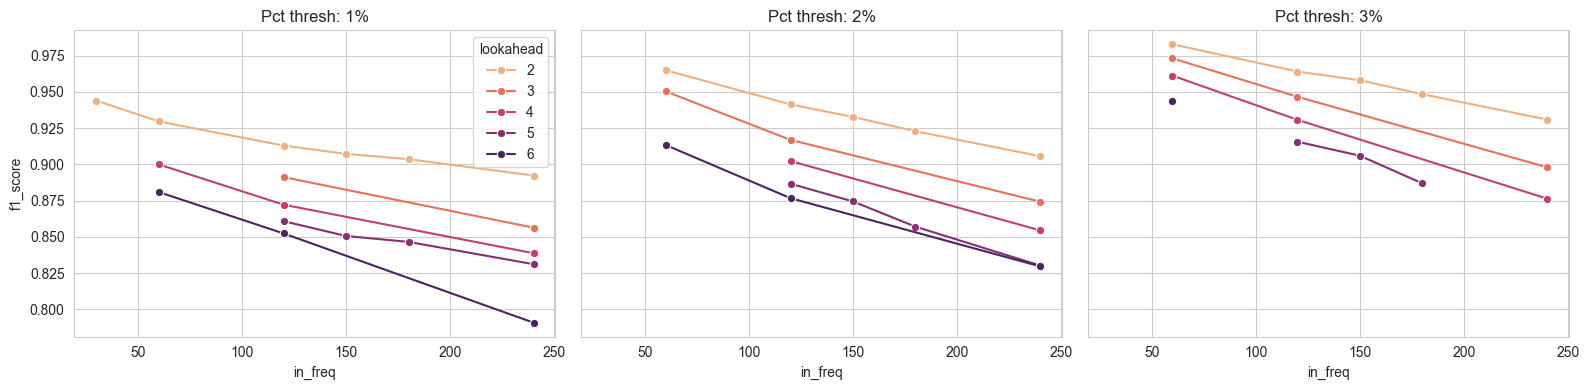

In [8]:
threshs = sorted(d['pct_thresh'].unique())
fig, axes = plt.subplots(1, 3, figsize = (16, 4), sharey = True, sharex = True)
for idx, ax in enumerate(axes.flatten()):
    sns.lineplot(data = d[(d['pct_thresh'] == threshs[idx])], x = 'in_freq', y = 'f1_score', hue = 'lookahead', ax = ax, palette = 'flare', marker = 'o',)
    ax.set_title(f'Pct thresh: {threshs[idx]}%')
    if idx != 0:
        ax.legend().remove()
plt.tight_layout()
plt.show()

In [9]:
d.rename(columns = {'score_0' : 'score_neither',
                    'score_1' : 'score_long',
                    'score_2' : 'score_short',
                    'score_3' : 'score_either'},
         inplace = True)
print('With individual label scores')
d[d['in_freq'] == 60].round(3).sort_values(by = ['lookahead', 'pct_thresh'])

With individual label scores


,in_freq,lookahead,pct_thresh,f1_score,score_neither,score_long,score_short,score_either
24,60,2,1,0.930,0.965,0.964,0.956,0.847
34,60,2,2,0.965,0.985,0.936,0.953,0.483
18,60,2,3,0.983,0.993,0.926,0.935,0.545
7,60,3,2,0.950,0.980,0.927,0.956,0.769
31,60,3,3,0.973,0.990,0.941,0.924,0.667
3,60,4,1,0.900,0.951,0.949,0.948,0.838
6,60,4,3,0.961,0.985,0.929,0.937,0.649
38,60,6,1,0.881,0.928,0.952,0.940,0.865
20,60,6,2,0.913,0.961,0.949,0.936,0.828
49,60,6,3,0.944,0.979,0.930,0.930,0.754


In [10]:
tgt_60 = tgt_df[tgt_df['in_freq'] == 60].pivot(columns = 'label', index = ['lookahead', 'pct_thresh'],values = 'pct_samples').reset_index()
tgt_60.reset_index(drop = True, inplace = True)
tgt_60 = tgt_60.round(3).sort_values(by = ['lookahead', 'pct_thresh'])
print('Label distribution:')
tgt_60[['lookahead', 'pct_thresh', 'neither', 'long', 'short', 'either']]

Label distribution:


label,lookahead,pct_thresh,neither,long,short,either
0,2,1,0.688,0.152,0.157,0.003
1,2,2,0.902,0.048,0.050,0.000
2,2,3,0.959,0.020,0.021,0.000
3,3,2,0.842,0.076,0.080,0.001
4,3,3,0.931,0.034,0.035,0.000
5,4,1,0.472,0.250,0.258,0.020
6,4,3,0.899,0.049,0.051,0.001
7,6,1,0.335,0.304,0.314,0.047
8,6,2,0.680,0.153,0.160,0.007
9,6,3,0.834,0.080,0.083,0.002
